In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split

In [2]:
train_csv_path = r'D:\ml_data\train.csv'
emotions = {0: 'Angry', 1:'Disgust', 2:'Fear',3: 'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
df = pd.read_csv(train_csv_path)
df.head(5)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


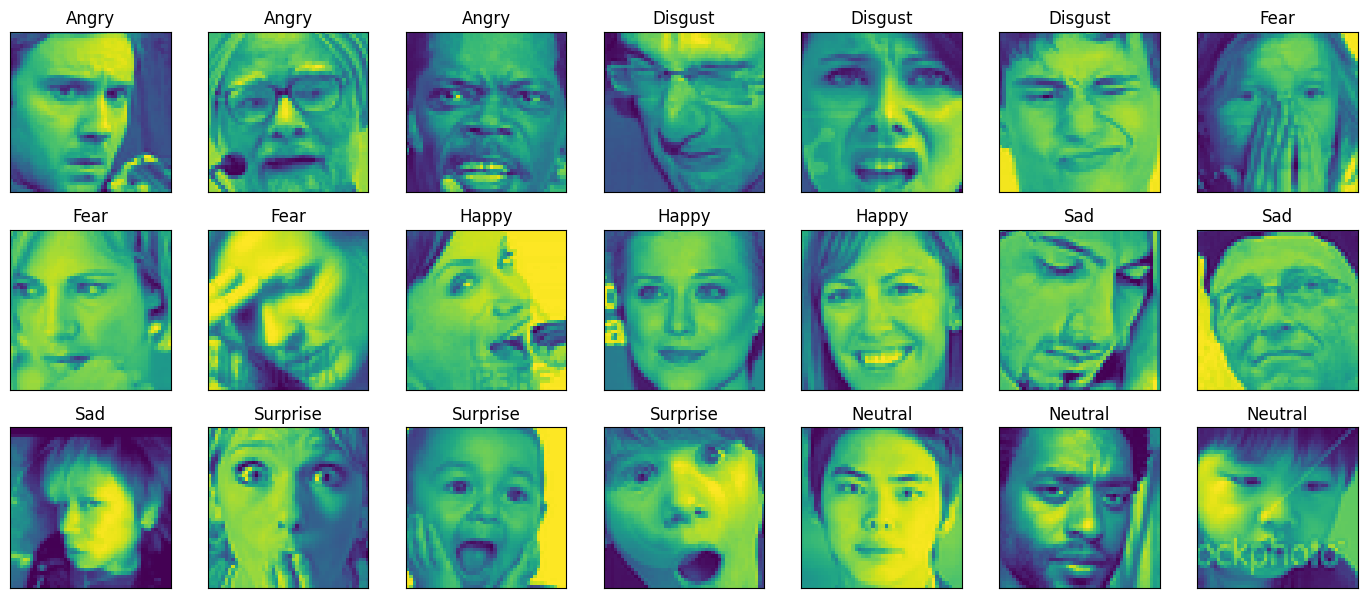

In [3]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        pyplot.tight_layout()

In [4]:
img_array = df.pixels.apply(lambda px : np.array(px.split(' ')).reshape(48, 48).astype('float32'))

In [5]:
img_array = np.stack(img_array, axis=0)
labels = df.emotion.values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size=0.2)

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0